# SARIMA Model for 24-Hour-Ahead Load Forecasting

This script implements a SARIMA model to forecast electricity load (MW) for the next 24 hours using 15-minute interval data from ENTSO-E for Germany (DE_LU). The model accounts for daily seasonality (period=96) and uses baseline parameters (1,1,1)(1,1,1,96). It processes historical data up to March 22, 2025, generates a 96-step forecast, and visualizes the last week's data with the forecast and 95% confidence intervals. Optional resampling to hourly data is included for faster computation.

In [ ]:
# Step 1: Install the required library
# In Google Colab, run this cell first to install the entsoe-py library.
# This library makes it easy to access the ENTSO-E API without dealing with raw HTTP requests.
!pip install entsoe-py

In [ ]:
from datetime import datetime, timedelta
import requests
import holidays
from entsoe import EntsoePandasClient  # For ENTSO-E API
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [ ]:
# User Input: ENTSO-E API Key (get free from transparency@entsoe.eu)
# If you don't have it yet, set api_key = 'your_key_here' and run; it will use fallback sample.
api_key = "your_key"  # Replace with your actual key!

# Date range: Historical data up to March 22, 2025 (today in scenario)
start_date = pd.Timestamp('2023-01-01', tz='Europe/Berlin')
end_date = pd.Timestamp('2025-03-22 23:00:00', tz='Europe/Berlin')

In [ ]:
client = EntsoePandasClient(api_key=api_key)
# Query actual total load (MW) for DE (includes 50Hertz/Berlin)
load_series = client.query_load('DE_LU', start=start_date, end=end_date)

load_column = 'Actual Load' if 'Actual Load' in load_series.columns else load_series.columns[0]
load_data = pd.DataFrame({'datetime': load_series.index, 'load_mw': load_series[load_column].values})

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming load_data is already created from your ENTSO-E query
# load_data = pd.DataFrame({'datetime': ..., 'load_mw': ...})

# Prepare the data: Set datetime index and ensure hourly frequency
load_data['datetime'] = pd.to_datetime(load_data['datetime'])
load_data.set_index('datetime', inplace=True)
load_data = load_data.asfreq('H')  # Fill any missing hours if needed
load_data = load_data.dropna()  # Drop any NaNs

# Fit the SARIMA model with baseline parameters
model = SARIMAX(
    load_data['load_mw'],
    order=(1, 1, 1),  # ARIMA component: p=1, d=1, q=1
    seasonal_order=(1, 1, 1, 24),  # Seasonal component: P=1, D=1, Q=1, s=24 (daily)
    enforce_stationarity=True,
    enforce_invertibility=True
)
model_fit = model.fit(disp=False)  # Fit the model (suppress convergence output)

# Print model summary
print(model_fit.summary())

/tmp/ipython-input-3202826181.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  load_data = load_data.asfreq('H')  # Fill any missing hours if needed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            load_mw   No. Observations:                19485
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -159363.239
Date:                            Mon, 15 Sep 2025   AIC                         318736.479
Time:                                    12:33:39   BIC                         318775.859
Sample:                                         0   HQIC                        318749.380
                                          - 19485                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3786      0.010     37.445      0.000       0.359       0.398
ma.L1          0.1575      0.011   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-2904591921.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(



24-Hour-Ahead Load Forecast:
                 datetime  forecast_load_mw     lower_ci     upper_ci
2025-03-22 23:00:00+01:00      46726.930713 45026.702072 48427.159354
2025-03-23 00:00:00+01:00      43699.012311 40582.611817 46815.412806
2025-03-23 01:00:00+01:00      41852.784574 37556.885499 46148.683648
2025-03-23 02:00:00+01:00      40943.504865 35653.212333 46233.797398
2025-03-23 03:00:00+01:00      40932.506839 34782.100423 47082.913254
2025-03-23 04:00:00+01:00      41652.453580 34739.738460 48565.168700
2025-03-23 05:00:00+01:00      43449.105189 35847.226982 51050.983395
2025-03-23 06:00:00+01:00      46924.925025 38690.335931 55159.514120
2025-03-23 07:00:00+01:00      50875.499439 42053.096351 59697.902527
2025-03-23 08:00:00+01:00      53783.184995 44409.627983 63156.742007
2025-03-23 09:00:00+01:00      55032.923205 45138.820505 64927.025905
2025-03-23 10:00:00+01:00      54975.782875 44587.168212 65364.397538
2025-03-23 11:00:00+01:00      54329.833220 43469.193588 651

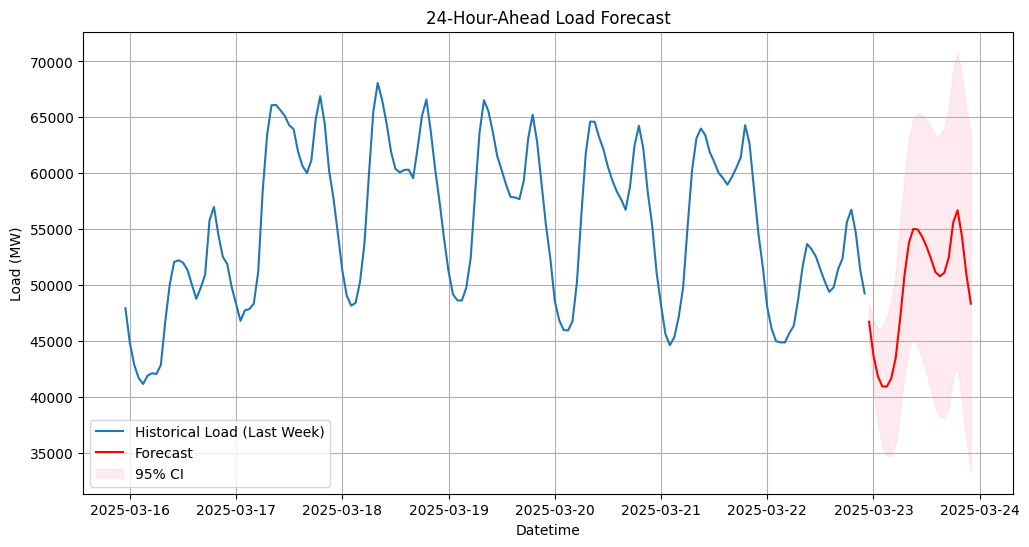

In [ ]:
# Forecast the next 24 hours
forecast_steps = 24
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()  # 95% confidence intervals

# Create datetime index for the forecast
forecast_index = pd.date_range(
    start=load_data.index[-1] + pd.Timedelta(hours=1),
    periods=forecast_steps,
    freq='H',
    tz='Europe/Berlin'
)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'datetime': forecast_index,
    'forecast_load_mw': forecast_mean,
    'lower_ci': forecast_conf_int.iloc[:, 0],
    'upper_ci': forecast_conf_int.iloc[:, 1]
})

# Display the forecast as a table
print("\n24-Hour-Ahead Load Forecast:")
print(forecast_df.to_string(index=False))

# Plot last 168 hours (1 week) of historical data + forecast
plt.figure(figsize=(12, 6))
plt.plot(load_data['load_mw'][-168:], label='Historical Load (Last Week)')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.title('24-Hour-Ahead Load Forecast')
plt.legend()
plt.grid(True)
plt.show()